In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 10000
lstm_hidden_size = 256
epochs = 20
experiment_id = (
    "classification-max_training_samples-10000-lstm_hidden_size-256-epochs-20"
)


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
def get_train_valid():
    train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

    if not enable_orig:
        train_x = []
        train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
    
    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


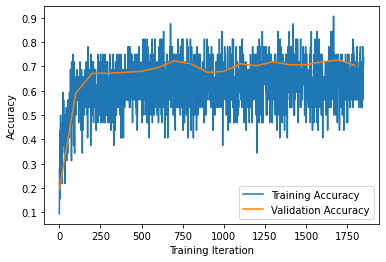

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x[:max_training_samples]),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    print(train_x_embeds.shape)
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=256
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.234 Validation Loss: 2.212 Accuracy: 0.016 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.223 Validation Loss: 2.212 Accuracy: 0.027 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.218 Validation Loss: 2.212 Accuracy: 0.029 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.216 Validation Loss: 2.212 Accuracy: 0.025 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.215 Validation Loss: 2.212 Accuracy: 0.025 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.214 Validation Loss: 2.212 Accuracy: 0.025 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.214 Validation Loss: 2.212 Accuracy: 0.025 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.214 Validation Loss: 2.212 Accuracy: 0.022 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.213 Validation Loss: 2.212 Accuracy: 0.021 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.213 Validation Loss: 2.212 Accuracy: 0.021 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.211 Validation Loss: 2.212 Accuracy: 0.025 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.210 Validation Loss: 2.212 Accuracy: 0.025 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.209 Validation Loss: 2.212 Accuracy: 0.025 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.207 Validation Loss: 2.212 Accuracy: 0.027 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.206 Validation Loss: 2.212 Accuracy: 0.027 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.205 Validation Loss: 2.212 Accuracy: 0.029 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.204 Validation Loss: 2.212 Accuracy: 0.029 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.203 Validation Loss: 2.212 Accuracy: 0.029 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.202 Validation Loss: 2.212 Accuracy: 0.029 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.201 Validation Loss: 2.212 Accuracy: 0.031 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 20 Loss: 2.198 Validation Loss: 2.212 Accuracy: 0.030 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 21 Loss: 2.196 Validation Loss: 2.212 Accuracy: 0.031 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 22 Loss: 2.194 Validation Loss: 2.212 Accuracy: 0.032 Validation Accuracy: 0.047:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 22 Loss: 2.194 Validation Loss: 2.212 Accuracy: 0.032 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 23 Loss: 2.192 Validation Loss: 2.212 Accuracy: 0.036 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 24 Loss: 2.190 Validation Loss: 2.212 Accuracy: 0.040 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 25 Loss: 2.187 Validation Loss: 2.212 Accuracy: 0.042 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 26 Loss: 2.185 Validation Loss: 2.212 Accuracy: 0.049 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 27 Loss: 2.183 Validation Loss: 2.212 Accuracy: 0.059 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 28 Loss: 2.180 Validation Loss: 2.212 Accuracy: 0.067 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 29 Loss: 2.177 Validation Loss: 2.212 Accuracy: 0.081 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 30 Loss: 2.174 Validation Loss: 2.212 Accuracy: 0.096 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 31 Loss: 2.172 Validation Loss: 2.212 Accuracy: 0.109 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 32 Loss: 2.169 Validation Loss: 2.212 Accuracy: 0.121 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 33 Loss: 2.167 Validation Loss: 2.212 Accuracy: 0.131 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 34 Loss: 2.165 Validation Loss: 2.212 Accuracy: 0.140 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 35 Loss: 2.163 Validation Loss: 2.212 Accuracy: 0.149 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 36 Loss: 2.161 Validation Loss: 2.212 Accuracy: 0.163 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 37 Loss: 2.158 Validation Loss: 2.212 Accuracy: 0.173 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 38 Loss: 2.155 Validation Loss: 2.212 Accuracy: 0.188 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

(10000, 10, 769)


Epoch: 0 Iteration: 39 Loss: 2.152 Validation Loss: 2.212 Accuracy: 0.190 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 40 Loss: 2.150 Validation Loss: 2.212 Accuracy: 0.198 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 41 Loss: 2.148 Validation Loss: 2.212 Accuracy: 0.198 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 42 Loss: 2.146 Validation Loss: 2.212 Accuracy: 0.205 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 43 Loss: 2.145 Validation Loss: 2.212 Accuracy: 0.206 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 44 Loss: 2.142 Validation Loss: 2.212 Accuracy: 0.219 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 45 Loss: 2.140 Validation Loss: 2.212 Accuracy: 0.226 Validation Accuracy: 0.047:  29%|██▉       | 23/79 [00:00<00:00, 222.26it/s]

Epoch: 0 Iteration: 45 Loss: 2.140 Validation Loss: 2.212 Accuracy: 0.226 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 46 Loss: 2.137 Validation Loss: 2.212 Accuracy: 0.227 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 47 Loss: 2.135 Validation Loss: 2.212 Accuracy: 0.228 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 48 Loss: 2.132 Validation Loss: 2.212 Accuracy: 0.227 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 49 Loss: 2.131 Validation Loss: 2.212 Accuracy: 0.228 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 50 Loss: 2.130 Validation Loss: 2.212 Accuracy: 0.223 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 51 Loss: 2.129 Validation Loss: 2.212 Accuracy: 0.225 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 52 Loss: 2.128 Validation Loss: 2.212 Accuracy: 0.230 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 53 Loss: 2.125 Validation Loss: 2.212 Accuracy: 0.238 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 54 Loss: 2.123 Validation Loss: 2.212 Accuracy: 0.240 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 55 Loss: 2.121 Validation Loss: 2.212 Accuracy: 0.245 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 56 Loss: 2.119 Validation Loss: 2.212 Accuracy: 0.249 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 57 Loss: 2.116 Validation Loss: 2.212 Accuracy: 0.250 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 58 Loss: 2.115 Validation Loss: 2.212 Accuracy: 0.253 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 59 Loss: 2.113 Validation Loss: 2.212 Accuracy: 0.252 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 60 Loss: 2.112 Validation Loss: 2.212 Accuracy: 0.262 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 61 Loss: 2.110 Validation Loss: 2.212 Accuracy: 0.263 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 62 Loss: 2.107 Validation Loss: 2.212 Accuracy: 0.270 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 63 Loss: 2.104 Validation Loss: 2.212 Accuracy: 0.273 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 64 Loss: 2.104 Validation Loss: 2.212 Accuracy: 0.266 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 65 Loss: 2.101 Validation Loss: 2.212 Accuracy: 0.271 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 66 Loss: 2.100 Validation Loss: 2.212 Accuracy: 0.268 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 67 Loss: 2.099 Validation Loss: 2.212 Accuracy: 0.267 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 68 Loss: 2.097 Validation Loss: 2.212 Accuracy: 0.270 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 69 Loss: 2.094 Validation Loss: 2.212 Accuracy: 0.274 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 70 Loss: 2.092 Validation Loss: 2.212 Accuracy: 0.270 Validation Accuracy: 0.047:  58%|█████▊    | 46/79 [00:00<00:00, 223.21it/s]

Epoch: 0 Iteration: 70 Loss: 2.092 Validation Loss: 2.212 Accuracy: 0.270 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 71 Loss: 2.088 Validation Loss: 2.212 Accuracy: 0.274 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 72 Loss: 2.087 Validation Loss: 2.212 Accuracy: 0.270 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 73 Loss: 2.085 Validation Loss: 2.212 Accuracy: 0.271 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 74 Loss: 2.083 Validation Loss: 2.212 Accuracy: 0.279 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 75 Loss: 2.080 Validation Loss: 2.212 Accuracy: 0.275 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 76 Loss: 2.079 Validation Loss: 2.212 Accuracy: 0.283 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 77 Loss: 2.078 Validation Loss: 2.212 Accuracy: 0.297 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 78 Loss: 2.075 Validation Loss: 2.212 Accuracy: 0.292 Validation Accuracy: 0.047:  90%|████████▉ | 71/79 [00:00<00:00, 232.13it/s]

Epoch: 0 Iteration: 78 Loss: 2.075 Validation Loss: 2.212 Accuracy: 0.292 Validation Accuracy: 0.047: 100%|██████████| 79/79 [00:00<00:00, 231.62it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 2.072 Validation Loss: 2.055 Accuracy: 0.309 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 2.068 Validation Loss: 2.055 Accuracy: 0.323 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 2.065 Validation Loss: 2.055 Accuracy: 0.333 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 2.063 Validation Loss: 2.055 Accuracy: 0.341 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 2.062 Validation Loss: 2.055 Accuracy: 0.343 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 2.056 Validation Loss: 2.055 Accuracy: 0.355 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 2.056 Validation Loss: 2.055 Accuracy: 0.357 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 2.053 Validation Loss: 2.055 Accuracy: 0.357 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 2.048 Validation Loss: 2.055 Accuracy: 0.362 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 2.048 Validation Loss: 2.055 Accuracy: 0.366 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 2.046 Validation Loss: 2.055 Accuracy: 0.362 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 2.044 Validation Loss: 2.055 Accuracy: 0.357 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.042 Validation Loss: 2.055 Accuracy: 0.355 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 2.039 Validation Loss: 2.055 Accuracy: 0.351 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 2.037 Validation Loss: 2.055 Accuracy: 0.352 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 2.034 Validation Loss: 2.055 Accuracy: 0.348 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 2.033 Validation Loss: 2.055 Accuracy: 0.348 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 2.031 Validation Loss: 2.055 Accuracy: 0.351 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 2.029 Validation Loss: 2.055 Accuracy: 0.348 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 2.027 Validation Loss: 2.055 Accuracy: 0.351 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 2.025 Validation Loss: 2.055 Accuracy: 0.353 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 2.021 Validation Loss: 2.055 Accuracy: 0.361 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 22 Loss: 2.023 Validation Loss: 2.055 Accuracy: 0.355 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 23 Loss: 2.022 Validation Loss: 2.055 Accuracy: 0.367 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 2.019 Validation Loss: 2.055 Accuracy: 0.372 Validation Accuracy: 0.199:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 2.019 Validation Loss: 2.055 Accuracy: 0.372 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 25 Loss: 2.019 Validation Loss: 2.055 Accuracy: 0.377 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 26 Loss: 2.016 Validation Loss: 2.055 Accuracy: 0.394 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 27 Loss: 2.012 Validation Loss: 2.055 Accuracy: 0.413 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 28 Loss: 2.014 Validation Loss: 2.055 Accuracy: 0.408 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 29 Loss: 2.010 Validation Loss: 2.055 Accuracy: 0.429 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 30 Loss: 2.008 Validation Loss: 2.055 Accuracy: 0.434 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 31 Loss: 2.006 Validation Loss: 2.055 Accuracy: 0.430 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 32 Loss: 2.004 Validation Loss: 2.055 Accuracy: 0.448 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 33 Loss: 2.002 Validation Loss: 2.055 Accuracy: 0.447 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 34 Loss: 1.999 Validation Loss: 2.055 Accuracy: 0.456 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 35 Loss: 1.999 Validation Loss: 2.055 Accuracy: 0.453 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 36 Loss: 1.995 Validation Loss: 2.055 Accuracy: 0.454 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 37 Loss: 1.992 Validation Loss: 2.055 Accuracy: 0.440 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 38 Loss: 1.988 Validation Loss: 2.055 Accuracy: 0.455 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 39 Loss: 1.986 Validation Loss: 2.055 Accuracy: 0.450 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 40 Loss: 1.984 Validation Loss: 2.055 Accuracy: 0.452 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 41 Loss: 1.984 Validation Loss: 2.055 Accuracy: 0.460 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 42 Loss: 1.976 Validation Loss: 2.055 Accuracy: 0.459 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 43 Loss: 1.976 Validation Loss: 2.055 Accuracy: 0.456 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 44 Loss: 1.975 Validation Loss: 2.055 Accuracy: 0.450 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 45 Loss: 1.975 Validation Loss: 2.055 Accuracy: 0.452 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 46 Loss: 1.974 Validation Loss: 2.055 Accuracy: 0.446 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 47 Loss: 1.971 Validation Loss: 2.055 Accuracy: 0.448 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 48 Loss: 1.966 Validation Loss: 2.055 Accuracy: 0.440 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 49 Loss: 1.962 Validation Loss: 2.055 Accuracy: 0.445 Validation Accuracy: 0.199:  32%|███▏      | 25/79 [00:00<00:00, 244.38it/s]

Epoch: 1 Iteration: 49 Loss: 1.962 Validation Loss: 2.055 Accuracy: 0.445 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 50 Loss: 1.957 Validation Loss: 2.055 Accuracy: 0.441 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 51 Loss: 1.957 Validation Loss: 2.055 Accuracy: 0.435 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 52 Loss: 1.954 Validation Loss: 2.055 Accuracy: 0.437 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 53 Loss: 1.950 Validation Loss: 2.055 Accuracy: 0.453 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 54 Loss: 1.950 Validation Loss: 2.055 Accuracy: 0.459 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 55 Loss: 1.949 Validation Loss: 2.055 Accuracy: 0.462 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 56 Loss: 1.946 Validation Loss: 2.055 Accuracy: 0.474 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 57 Loss: 1.947 Validation Loss: 2.055 Accuracy: 0.479 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 58 Loss: 1.946 Validation Loss: 2.055 Accuracy: 0.487 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 59 Loss: 1.942 Validation Loss: 2.055 Accuracy: 0.489 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 60 Loss: 1.942 Validation Loss: 2.055 Accuracy: 0.497 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 61 Loss: 1.942 Validation Loss: 2.055 Accuracy: 0.505 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 62 Loss: 1.944 Validation Loss: 2.055 Accuracy: 0.504 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 63 Loss: 1.941 Validation Loss: 2.055 Accuracy: 0.494 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 64 Loss: 1.935 Validation Loss: 2.055 Accuracy: 0.498 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 65 Loss: 1.928 Validation Loss: 2.055 Accuracy: 0.510 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 66 Loss: 1.925 Validation Loss: 2.055 Accuracy: 0.509 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 67 Loss: 1.925 Validation Loss: 2.055 Accuracy: 0.512 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 68 Loss: 1.925 Validation Loss: 2.055 Accuracy: 0.514 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 69 Loss: 1.925 Validation Loss: 2.055 Accuracy: 0.512 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 70 Loss: 1.924 Validation Loss: 2.055 Accuracy: 0.513 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 71 Loss: 1.921 Validation Loss: 2.055 Accuracy: 0.511 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 72 Loss: 1.923 Validation Loss: 2.055 Accuracy: 0.510 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 73 Loss: 1.921 Validation Loss: 2.055 Accuracy: 0.522 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 74 Loss: 1.920 Validation Loss: 2.055 Accuracy: 0.514 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 75 Loss: 1.917 Validation Loss: 2.055 Accuracy: 0.508 Validation Accuracy: 0.199:  63%|██████▎   | 50/79 [00:00<00:00, 247.23it/s]

Epoch: 1 Iteration: 75 Loss: 1.917 Validation Loss: 2.055 Accuracy: 0.508 Validation Accuracy: 0.199:  96%|█████████▌| 76/79 [00:00<00:00, 248.90it/s]

Epoch: 1 Iteration: 76 Loss: 1.918 Validation Loss: 2.055 Accuracy: 0.502 Validation Accuracy: 0.199:  96%|█████████▌| 76/79 [00:00<00:00, 248.90it/s]

Epoch: 1 Iteration: 77 Loss: 1.917 Validation Loss: 2.055 Accuracy: 0.496 Validation Accuracy: 0.199:  96%|█████████▌| 76/79 [00:00<00:00, 248.90it/s]

Epoch: 1 Iteration: 78 Loss: 1.918 Validation Loss: 2.055 Accuracy: 0.493 Validation Accuracy: 0.199:  96%|█████████▌| 76/79 [00:00<00:00, 248.90it/s]

Epoch: 1 Iteration: 78 Loss: 1.918 Validation Loss: 2.055 Accuracy: 0.493 Validation Accuracy: 0.199: 100%|██████████| 79/79 [00:00<00:00, 249.60it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 1.916 Validation Loss: 1.894 Accuracy: 0.496 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 1.912 Validation Loss: 1.894 Accuracy: 0.492 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 1.910 Validation Loss: 1.894 Accuracy: 0.495 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 1.905 Validation Loss: 1.894 Accuracy: 0.497 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 1.901 Validation Loss: 1.894 Accuracy: 0.490 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 1.903 Validation Loss: 1.894 Accuracy: 0.499 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 1.904 Validation Loss: 1.894 Accuracy: 0.498 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 1.901 Validation Loss: 1.894 Accuracy: 0.503 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 1.902 Validation Loss: 1.894 Accuracy: 0.497 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 1.898 Validation Loss: 1.894 Accuracy: 0.499 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 1.894 Validation Loss: 1.894 Accuracy: 0.499 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 1.894 Validation Loss: 1.894 Accuracy: 0.498 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 1.890 Validation Loss: 1.894 Accuracy: 0.502 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 1.888 Validation Loss: 1.894 Accuracy: 0.499 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 1.886 Validation Loss: 1.894 Accuracy: 0.499 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 1.883 Validation Loss: 1.894 Accuracy: 0.491 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 1.882 Validation Loss: 1.894 Accuracy: 0.497 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 1.876 Validation Loss: 1.894 Accuracy: 0.507 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 1.868 Validation Loss: 1.894 Accuracy: 0.527 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 1.862 Validation Loss: 1.894 Accuracy: 0.529 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 1.858 Validation Loss: 1.894 Accuracy: 0.535 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 21 Loss: 1.858 Validation Loss: 1.894 Accuracy: 0.545 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 22 Loss: 1.855 Validation Loss: 1.894 Accuracy: 0.548 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 23 Loss: 1.853 Validation Loss: 1.894 Accuracy: 0.558 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 24 Loss: 1.850 Validation Loss: 1.894 Accuracy: 0.562 Validation Accuracy: 0.310:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 24 Loss: 1.850 Validation Loss: 1.894 Accuracy: 0.562 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 25 Loss: 1.844 Validation Loss: 1.894 Accuracy: 0.577 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 26 Loss: 1.841 Validation Loss: 1.894 Accuracy: 0.583 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 27 Loss: 1.835 Validation Loss: 1.894 Accuracy: 0.579 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 28 Loss: 1.830 Validation Loss: 1.894 Accuracy: 0.569 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 29 Loss: 1.828 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 30 Loss: 1.825 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 31 Loss: 1.820 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 32 Loss: 1.814 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 33 Loss: 1.810 Validation Loss: 1.894 Accuracy: 0.570 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 34 Loss: 1.807 Validation Loss: 1.894 Accuracy: 0.570 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 35 Loss: 1.802 Validation Loss: 1.894 Accuracy: 0.566 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 36 Loss: 1.796 Validation Loss: 1.894 Accuracy: 0.560 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 37 Loss: 1.794 Validation Loss: 1.894 Accuracy: 0.565 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 38 Loss: 1.793 Validation Loss: 1.894 Accuracy: 0.577 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 39 Loss: 1.788 Validation Loss: 1.894 Accuracy: 0.580 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 40 Loss: 1.790 Validation Loss: 1.894 Accuracy: 0.576 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 41 Loss: 1.787 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 42 Loss: 1.785 Validation Loss: 1.894 Accuracy: 0.575 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 43 Loss: 1.784 Validation Loss: 1.894 Accuracy: 0.577 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 44 Loss: 1.780 Validation Loss: 1.894 Accuracy: 0.578 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 45 Loss: 1.781 Validation Loss: 1.894 Accuracy: 0.577 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 46 Loss: 1.777 Validation Loss: 1.894 Accuracy: 0.577 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 47 Loss: 1.780 Validation Loss: 1.894 Accuracy: 0.565 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 48 Loss: 1.773 Validation Loss: 1.894 Accuracy: 0.565 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 49 Loss: 1.766 Validation Loss: 1.894 Accuracy: 0.570 Validation Accuracy: 0.310:  32%|███▏      | 25/79 [00:00<00:00, 244.50it/s]

Epoch: 2 Iteration: 49 Loss: 1.766 Validation Loss: 1.894 Accuracy: 0.570 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 50 Loss: 1.761 Validation Loss: 1.894 Accuracy: 0.577 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 51 Loss: 1.754 Validation Loss: 1.894 Accuracy: 0.588 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 52 Loss: 1.759 Validation Loss: 1.894 Accuracy: 0.581 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 53 Loss: 1.755 Validation Loss: 1.894 Accuracy: 0.582 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 54 Loss: 1.753 Validation Loss: 1.894 Accuracy: 0.582 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 55 Loss: 1.748 Validation Loss: 1.894 Accuracy: 0.584 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 56 Loss: 1.751 Validation Loss: 1.894 Accuracy: 0.579 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 57 Loss: 1.753 Validation Loss: 1.894 Accuracy: 0.577 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 58 Loss: 1.749 Validation Loss: 1.894 Accuracy: 0.576 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 59 Loss: 1.751 Validation Loss: 1.894 Accuracy: 0.564 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 60 Loss: 1.744 Validation Loss: 1.894 Accuracy: 0.562 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 61 Loss: 1.740 Validation Loss: 1.894 Accuracy: 0.561 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 62 Loss: 1.735 Validation Loss: 1.894 Accuracy: 0.561 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 63 Loss: 1.730 Validation Loss: 1.894 Accuracy: 0.569 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 64 Loss: 1.730 Validation Loss: 1.894 Accuracy: 0.570 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 65 Loss: 1.725 Validation Loss: 1.894 Accuracy: 0.566 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 66 Loss: 1.723 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 67 Loss: 1.715 Validation Loss: 1.894 Accuracy: 0.584 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 68 Loss: 1.718 Validation Loss: 1.894 Accuracy: 0.577 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 69 Loss: 1.718 Validation Loss: 1.894 Accuracy: 0.579 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 70 Loss: 1.716 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 71 Loss: 1.721 Validation Loss: 1.894 Accuracy: 0.565 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 72 Loss: 1.712 Validation Loss: 1.894 Accuracy: 0.570 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 73 Loss: 1.712 Validation Loss: 1.894 Accuracy: 0.557 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 74 Loss: 1.706 Validation Loss: 1.894 Accuracy: 0.560 Validation Accuracy: 0.310:  63%|██████▎   | 50/79 [00:00<00:00, 245.39it/s]

Epoch: 2 Iteration: 74 Loss: 1.706 Validation Loss: 1.894 Accuracy: 0.560 Validation Accuracy: 0.310:  95%|█████████▍| 75/79 [00:00<00:00, 243.95it/s]

Epoch: 2 Iteration: 75 Loss: 1.706 Validation Loss: 1.894 Accuracy: 0.563 Validation Accuracy: 0.310:  95%|█████████▍| 75/79 [00:00<00:00, 243.95it/s]

Epoch: 2 Iteration: 76 Loss: 1.703 Validation Loss: 1.894 Accuracy: 0.562 Validation Accuracy: 0.310:  95%|█████████▍| 75/79 [00:00<00:00, 243.95it/s]

Epoch: 2 Iteration: 77 Loss: 1.692 Validation Loss: 1.894 Accuracy: 0.564 Validation Accuracy: 0.310:  95%|█████████▍| 75/79 [00:00<00:00, 243.95it/s]

Epoch: 2 Iteration: 78 Loss: 1.690 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310:  95%|█████████▍| 75/79 [00:00<00:00, 243.95it/s]

Epoch: 2 Iteration: 78 Loss: 1.690 Validation Loss: 1.894 Accuracy: 0.573 Validation Accuracy: 0.310: 100%|██████████| 79/79 [00:00<00:00, 245.73it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 1.684 Validation Loss: 1.657 Accuracy: 0.577 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 1.681 Validation Loss: 1.657 Accuracy: 0.580 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 1.676 Validation Loss: 1.657 Accuracy: 0.584 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 1.672 Validation Loss: 1.657 Accuracy: 0.585 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 1.673 Validation Loss: 1.657 Accuracy: 0.589 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 1.669 Validation Loss: 1.657 Accuracy: 0.583 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 1.666 Validation Loss: 1.657 Accuracy: 0.584 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 1.659 Validation Loss: 1.657 Accuracy: 0.588 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 1.659 Validation Loss: 1.657 Accuracy: 0.581 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 1.652 Validation Loss: 1.657 Accuracy: 0.579 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 1.651 Validation Loss: 1.657 Accuracy: 0.568 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 1.650 Validation Loss: 1.657 Accuracy: 0.567 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 1.644 Validation Loss: 1.657 Accuracy: 0.565 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 1.644 Validation Loss: 1.657 Accuracy: 0.563 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 1.636 Validation Loss: 1.657 Accuracy: 0.571 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 1.632 Validation Loss: 1.657 Accuracy: 0.577 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 1.630 Validation Loss: 1.657 Accuracy: 0.571 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 1.621 Validation Loss: 1.657 Accuracy: 0.568 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 1.616 Validation Loss: 1.657 Accuracy: 0.571 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 1.615 Validation Loss: 1.657 Accuracy: 0.566 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 1.610 Validation Loss: 1.657 Accuracy: 0.576 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 21 Loss: 1.606 Validation Loss: 1.657 Accuracy: 0.580 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 22 Loss: 1.602 Validation Loss: 1.657 Accuracy: 0.579 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 1.597 Validation Loss: 1.657 Accuracy: 0.578 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 24 Loss: 1.591 Validation Loss: 1.657 Accuracy: 0.580 Validation Accuracy: 0.382:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 24 Loss: 1.591 Validation Loss: 1.657 Accuracy: 0.580 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 25 Loss: 1.585 Validation Loss: 1.657 Accuracy: 0.579 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 26 Loss: 1.578 Validation Loss: 1.657 Accuracy: 0.590 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 27 Loss: 1.578 Validation Loss: 1.657 Accuracy: 0.592 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 28 Loss: 1.571 Validation Loss: 1.657 Accuracy: 0.594 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 29 Loss: 1.565 Validation Loss: 1.657 Accuracy: 0.605 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 30 Loss: 1.555 Validation Loss: 1.657 Accuracy: 0.612 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 31 Loss: 1.549 Validation Loss: 1.657 Accuracy: 0.609 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 32 Loss: 1.545 Validation Loss: 1.657 Accuracy: 0.620 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 33 Loss: 1.541 Validation Loss: 1.657 Accuracy: 0.619 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 34 Loss: 1.541 Validation Loss: 1.657 Accuracy: 0.611 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 35 Loss: 1.538 Validation Loss: 1.657 Accuracy: 0.613 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 36 Loss: 1.526 Validation Loss: 1.657 Accuracy: 0.613 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 37 Loss: 1.515 Validation Loss: 1.657 Accuracy: 0.622 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 38 Loss: 1.509 Validation Loss: 1.657 Accuracy: 0.630 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 39 Loss: 1.501 Validation Loss: 1.657 Accuracy: 0.630 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 40 Loss: 1.503 Validation Loss: 1.657 Accuracy: 0.619 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 41 Loss: 1.501 Validation Loss: 1.657 Accuracy: 0.614 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 42 Loss: 1.497 Validation Loss: 1.657 Accuracy: 0.607 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 43 Loss: 1.494 Validation Loss: 1.657 Accuracy: 0.612 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 44 Loss: 1.485 Validation Loss: 1.657 Accuracy: 0.617 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 45 Loss: 1.482 Validation Loss: 1.657 Accuracy: 0.614 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 46 Loss: 1.478 Validation Loss: 1.657 Accuracy: 0.616 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 47 Loss: 1.480 Validation Loss: 1.657 Accuracy: 0.598 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 48 Loss: 1.479 Validation Loss: 1.657 Accuracy: 0.588 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 49 Loss: 1.480 Validation Loss: 1.657 Accuracy: 0.585 Validation Accuracy: 0.382:  32%|███▏      | 25/79 [00:00<00:00, 242.34it/s]

Epoch: 3 Iteration: 49 Loss: 1.480 Validation Loss: 1.657 Accuracy: 0.585 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 50 Loss: 1.477 Validation Loss: 1.657 Accuracy: 0.595 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 51 Loss: 1.476 Validation Loss: 1.657 Accuracy: 0.597 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 52 Loss: 1.466 Validation Loss: 1.657 Accuracy: 0.608 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 53 Loss: 1.463 Validation Loss: 1.657 Accuracy: 0.602 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 54 Loss: 1.458 Validation Loss: 1.657 Accuracy: 0.599 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 55 Loss: 1.456 Validation Loss: 1.657 Accuracy: 0.597 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 56 Loss: 1.451 Validation Loss: 1.657 Accuracy: 0.594 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 57 Loss: 1.453 Validation Loss: 1.657 Accuracy: 0.602 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 58 Loss: 1.456 Validation Loss: 1.657 Accuracy: 0.605 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 59 Loss: 1.454 Validation Loss: 1.657 Accuracy: 0.605 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 60 Loss: 1.445 Validation Loss: 1.657 Accuracy: 0.602 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 61 Loss: 1.440 Validation Loss: 1.657 Accuracy: 0.605 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 62 Loss: 1.441 Validation Loss: 1.657 Accuracy: 0.593 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 63 Loss: 1.435 Validation Loss: 1.657 Accuracy: 0.605 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 64 Loss: 1.432 Validation Loss: 1.657 Accuracy: 0.610 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 65 Loss: 1.422 Validation Loss: 1.657 Accuracy: 0.623 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 66 Loss: 1.422 Validation Loss: 1.657 Accuracy: 0.616 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 67 Loss: 1.415 Validation Loss: 1.657 Accuracy: 0.612 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 68 Loss: 1.418 Validation Loss: 1.657 Accuracy: 0.598 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 69 Loss: 1.413 Validation Loss: 1.657 Accuracy: 0.592 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 70 Loss: 1.416 Validation Loss: 1.657 Accuracy: 0.588 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 71 Loss: 1.412 Validation Loss: 1.657 Accuracy: 0.583 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 72 Loss: 1.420 Validation Loss: 1.657 Accuracy: 0.577 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 73 Loss: 1.414 Validation Loss: 1.657 Accuracy: 0.569 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 74 Loss: 1.405 Validation Loss: 1.657 Accuracy: 0.567 Validation Accuracy: 0.382:  63%|██████▎   | 50/79 [00:00<00:00, 245.22it/s]

Epoch: 3 Iteration: 74 Loss: 1.405 Validation Loss: 1.657 Accuracy: 0.567 Validation Accuracy: 0.382:  95%|█████████▍| 75/79 [00:00<00:00, 246.57it/s]

Epoch: 3 Iteration: 75 Loss: 1.405 Validation Loss: 1.657 Accuracy: 0.552 Validation Accuracy: 0.382:  95%|█████████▍| 75/79 [00:00<00:00, 246.57it/s]

Epoch: 3 Iteration: 76 Loss: 1.402 Validation Loss: 1.657 Accuracy: 0.559 Validation Accuracy: 0.382:  95%|█████████▍| 75/79 [00:00<00:00, 246.57it/s]

Epoch: 3 Iteration: 77 Loss: 1.399 Validation Loss: 1.657 Accuracy: 0.567 Validation Accuracy: 0.382:  95%|█████████▍| 75/79 [00:00<00:00, 246.57it/s]

Epoch: 3 Iteration: 78 Loss: 1.391 Validation Loss: 1.657 Accuracy: 0.574 Validation Accuracy: 0.382:  95%|█████████▍| 75/79 [00:00<00:00, 246.57it/s]

Epoch: 3 Iteration: 78 Loss: 1.391 Validation Loss: 1.657 Accuracy: 0.574 Validation Accuracy: 0.382: 100%|██████████| 79/79 [00:00<00:00, 246.90it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 1.383 Validation Loss: 1.327 Accuracy: 0.580 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 1.379 Validation Loss: 1.327 Accuracy: 0.580 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 1.374 Validation Loss: 1.327 Accuracy: 0.587 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 1.362 Validation Loss: 1.327 Accuracy: 0.600 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 1.359 Validation Loss: 1.327 Accuracy: 0.609 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 1.362 Validation Loss: 1.327 Accuracy: 0.602 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 1.362 Validation Loss: 1.327 Accuracy: 0.609 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 1.356 Validation Loss: 1.327 Accuracy: 0.609 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 1.352 Validation Loss: 1.327 Accuracy: 0.605 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 1.335 Validation Loss: 1.327 Accuracy: 0.616 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 1.322 Validation Loss: 1.327 Accuracy: 0.627 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 1.315 Validation Loss: 1.327 Accuracy: 0.627 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 1.313 Validation Loss: 1.327 Accuracy: 0.620 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 1.302 Validation Loss: 1.327 Accuracy: 0.619 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 1.299 Validation Loss: 1.327 Accuracy: 0.609 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 1.296 Validation Loss: 1.327 Accuracy: 0.618 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 1.287 Validation Loss: 1.327 Accuracy: 0.619 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 1.284 Validation Loss: 1.327 Accuracy: 0.622 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 1.279 Validation Loss: 1.327 Accuracy: 0.627 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 1.282 Validation Loss: 1.327 Accuracy: 0.620 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 1.284 Validation Loss: 1.327 Accuracy: 0.605 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 1.279 Validation Loss: 1.327 Accuracy: 0.611 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 22 Loss: 1.275 Validation Loss: 1.327 Accuracy: 0.616 Validation Accuracy: 0.429:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 22 Loss: 1.275 Validation Loss: 1.327 Accuracy: 0.616 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 23 Loss: 1.273 Validation Loss: 1.327 Accuracy: 0.616 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 24 Loss: 1.271 Validation Loss: 1.327 Accuracy: 0.621 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 25 Loss: 1.270 Validation Loss: 1.327 Accuracy: 0.613 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 26 Loss: 1.264 Validation Loss: 1.327 Accuracy: 0.615 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 27 Loss: 1.256 Validation Loss: 1.327 Accuracy: 0.616 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 28 Loss: 1.252 Validation Loss: 1.327 Accuracy: 0.611 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 29 Loss: 1.249 Validation Loss: 1.327 Accuracy: 0.618 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 30 Loss: 1.252 Validation Loss: 1.327 Accuracy: 0.625 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 31 Loss: 1.253 Validation Loss: 1.327 Accuracy: 0.619 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 32 Loss: 1.243 Validation Loss: 1.327 Accuracy: 0.623 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 33 Loss: 1.240 Validation Loss: 1.327 Accuracy: 0.626 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 34 Loss: 1.242 Validation Loss: 1.327 Accuracy: 0.615 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 35 Loss: 1.245 Validation Loss: 1.327 Accuracy: 0.612 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 36 Loss: 1.238 Validation Loss: 1.327 Accuracy: 0.613 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 37 Loss: 1.236 Validation Loss: 1.327 Accuracy: 0.609 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 38 Loss: 1.235 Validation Loss: 1.327 Accuracy: 0.613 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 39 Loss: 1.230 Validation Loss: 1.327 Accuracy: 0.606 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 40 Loss: 1.227 Validation Loss: 1.327 Accuracy: 0.605 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 41 Loss: 1.231 Validation Loss: 1.327 Accuracy: 0.606 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 42 Loss: 1.230 Validation Loss: 1.327 Accuracy: 0.603 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 43 Loss: 1.235 Validation Loss: 1.327 Accuracy: 0.598 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 44 Loss: 1.234 Validation Loss: 1.327 Accuracy: 0.609 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 45 Loss: 1.226 Validation Loss: 1.327 Accuracy: 0.618 Validation Accuracy: 0.429:  29%|██▉       | 23/79 [00:00<00:00, 227.79it/s]

Epoch: 4 Iteration: 45 Loss: 1.226 Validation Loss: 1.327 Accuracy: 0.618 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 46 Loss: 1.230 Validation Loss: 1.327 Accuracy: 0.616 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 47 Loss: 1.232 Validation Loss: 1.327 Accuracy: 0.614 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 48 Loss: 1.229 Validation Loss: 1.327 Accuracy: 0.617 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 49 Loss: 1.227 Validation Loss: 1.327 Accuracy: 0.623 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 50 Loss: 1.228 Validation Loss: 1.327 Accuracy: 0.621 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 51 Loss: 1.220 Validation Loss: 1.327 Accuracy: 0.622 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 52 Loss: 1.223 Validation Loss: 1.327 Accuracy: 0.617 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 53 Loss: 1.221 Validation Loss: 1.327 Accuracy: 0.620 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 54 Loss: 1.208 Validation Loss: 1.327 Accuracy: 0.625 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 55 Loss: 1.200 Validation Loss: 1.327 Accuracy: 0.628 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 56 Loss: 1.203 Validation Loss: 1.327 Accuracy: 0.628 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 57 Loss: 1.208 Validation Loss: 1.327 Accuracy: 0.627 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 58 Loss: 1.198 Validation Loss: 1.327 Accuracy: 0.631 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 59 Loss: 1.196 Validation Loss: 1.327 Accuracy: 0.623 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 60 Loss: 1.193 Validation Loss: 1.327 Accuracy: 0.624 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 61 Loss: 1.187 Validation Loss: 1.327 Accuracy: 0.623 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 62 Loss: 1.186 Validation Loss: 1.327 Accuracy: 0.625 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 63 Loss: 1.180 Validation Loss: 1.327 Accuracy: 0.622 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 64 Loss: 1.178 Validation Loss: 1.327 Accuracy: 0.615 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 65 Loss: 1.173 Validation Loss: 1.327 Accuracy: 0.616 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 66 Loss: 1.170 Validation Loss: 1.327 Accuracy: 0.615 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 67 Loss: 1.164 Validation Loss: 1.327 Accuracy: 0.619 Validation Accuracy: 0.429:  58%|█████▊    | 46/79 [00:00<00:00, 141.38it/s]

Epoch: 4 Iteration: 67 Loss: 1.164 Validation Loss: 1.327 Accuracy: 0.619 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 68 Loss: 1.160 Validation Loss: 1.327 Accuracy: 0.616 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 69 Loss: 1.159 Validation Loss: 1.327 Accuracy: 0.625 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 70 Loss: 1.158 Validation Loss: 1.327 Accuracy: 0.622 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 71 Loss: 1.156 Validation Loss: 1.327 Accuracy: 0.627 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 72 Loss: 1.153 Validation Loss: 1.327 Accuracy: 0.627 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 73 Loss: 1.148 Validation Loss: 1.327 Accuracy: 0.632 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 74 Loss: 1.147 Validation Loss: 1.327 Accuracy: 0.641 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 75 Loss: 1.142 Validation Loss: 1.327 Accuracy: 0.641 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 76 Loss: 1.139 Validation Loss: 1.327 Accuracy: 0.641 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 77 Loss: 1.136 Validation Loss: 1.327 Accuracy: 0.639 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 78 Loss: 1.144 Validation Loss: 1.327 Accuracy: 0.634 Validation Accuracy: 0.429:  86%|████████▌ | 68/79 [00:00<00:00, 167.75it/s]

Epoch: 4 Iteration: 78 Loss: 1.144 Validation Loss: 1.327 Accuracy: 0.634 Validation Accuracy: 0.429: 100%|██████████| 79/79 [00:00<00:00, 173.64it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 1.147 Validation Loss: 1.089 Accuracy: 0.623 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 1.146 Validation Loss: 1.089 Accuracy: 0.623 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 1.139 Validation Loss: 1.089 Accuracy: 0.629 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 1.135 Validation Loss: 1.089 Accuracy: 0.631 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.137 Validation Loss: 1.089 Accuracy: 0.620 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 1.129 Validation Loss: 1.089 Accuracy: 0.617 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 1.130 Validation Loss: 1.089 Accuracy: 0.615 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 1.133 Validation Loss: 1.089 Accuracy: 0.609 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 1.133 Validation Loss: 1.089 Accuracy: 0.609 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 1.131 Validation Loss: 1.089 Accuracy: 0.613 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 1.128 Validation Loss: 1.089 Accuracy: 0.625 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 1.123 Validation Loss: 1.089 Accuracy: 0.634 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 1.122 Validation Loss: 1.089 Accuracy: 0.626 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 1.120 Validation Loss: 1.089 Accuracy: 0.620 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 1.126 Validation Loss: 1.089 Accuracy: 0.621 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 1.124 Validation Loss: 1.089 Accuracy: 0.622 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 1.122 Validation Loss: 1.089 Accuracy: 0.625 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 1.124 Validation Loss: 1.089 Accuracy: 0.632 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 1.113 Validation Loss: 1.089 Accuracy: 0.642 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 1.100 Validation Loss: 1.089 Accuracy: 0.648 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 1.089 Validation Loss: 1.089 Accuracy: 0.646 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 1.079 Validation Loss: 1.089 Accuracy: 0.649 Validation Accuracy: 0.465:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 1.079 Validation Loss: 1.089 Accuracy: 0.649 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 22 Loss: 1.080 Validation Loss: 1.089 Accuracy: 0.654 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 23 Loss: 1.080 Validation Loss: 1.089 Accuracy: 0.659 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 24 Loss: 1.068 Validation Loss: 1.089 Accuracy: 0.672 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 25 Loss: 1.067 Validation Loss: 1.089 Accuracy: 0.677 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 26 Loss: 1.062 Validation Loss: 1.089 Accuracy: 0.675 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 27 Loss: 1.051 Validation Loss: 1.089 Accuracy: 0.684 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 28 Loss: 1.048 Validation Loss: 1.089 Accuracy: 0.677 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 29 Loss: 1.055 Validation Loss: 1.089 Accuracy: 0.662 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 30 Loss: 1.060 Validation Loss: 1.089 Accuracy: 0.660 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 31 Loss: 1.050 Validation Loss: 1.089 Accuracy: 0.662 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 32 Loss: 1.048 Validation Loss: 1.089 Accuracy: 0.663 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 33 Loss: 1.047 Validation Loss: 1.089 Accuracy: 0.659 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 34 Loss: 1.045 Validation Loss: 1.089 Accuracy: 0.651 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 35 Loss: 1.050 Validation Loss: 1.089 Accuracy: 0.640 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 36 Loss: 1.051 Validation Loss: 1.089 Accuracy: 0.644 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 37 Loss: 1.042 Validation Loss: 1.089 Accuracy: 0.641 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 38 Loss: 1.049 Validation Loss: 1.089 Accuracy: 0.637 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 39 Loss: 1.058 Validation Loss: 1.089 Accuracy: 0.645 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 40 Loss: 1.054 Validation Loss: 1.089 Accuracy: 0.654 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 41 Loss: 1.056 Validation Loss: 1.089 Accuracy: 0.647 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 42 Loss: 1.058 Validation Loss: 1.089 Accuracy: 0.638 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 43 Loss: 1.062 Validation Loss: 1.089 Accuracy: 0.636 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 44 Loss: 1.068 Validation Loss: 1.089 Accuracy: 0.642 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 45 Loss: 1.069 Validation Loss: 1.089 Accuracy: 0.648 Validation Accuracy: 0.465:  28%|██▊       | 22/79 [00:00<00:00, 214.27it/s]

Epoch: 5 Iteration: 45 Loss: 1.069 Validation Loss: 1.089 Accuracy: 0.648 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 46 Loss: 1.070 Validation Loss: 1.089 Accuracy: 0.647 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 47 Loss: 1.068 Validation Loss: 1.089 Accuracy: 0.648 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 48 Loss: 1.063 Validation Loss: 1.089 Accuracy: 0.652 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 49 Loss: 1.055 Validation Loss: 1.089 Accuracy: 0.653 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 50 Loss: 1.053 Validation Loss: 1.089 Accuracy: 0.645 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 51 Loss: 1.067 Validation Loss: 1.089 Accuracy: 0.637 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 52 Loss: 1.064 Validation Loss: 1.089 Accuracy: 0.648 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 53 Loss: 1.057 Validation Loss: 1.089 Accuracy: 0.655 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 54 Loss: 1.046 Validation Loss: 1.089 Accuracy: 0.662 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 55 Loss: 1.043 Validation Loss: 1.089 Accuracy: 0.659 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 56 Loss: 1.041 Validation Loss: 1.089 Accuracy: 0.662 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 57 Loss: 1.044 Validation Loss: 1.089 Accuracy: 0.660 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 58 Loss: 1.033 Validation Loss: 1.089 Accuracy: 0.666 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 59 Loss: 1.027 Validation Loss: 1.089 Accuracy: 0.665 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 60 Loss: 1.028 Validation Loss: 1.089 Accuracy: 0.669 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 61 Loss: 1.031 Validation Loss: 1.089 Accuracy: 0.674 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 62 Loss: 1.024 Validation Loss: 1.089 Accuracy: 0.673 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 63 Loss: 1.015 Validation Loss: 1.089 Accuracy: 0.677 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 64 Loss: 1.017 Validation Loss: 1.089 Accuracy: 0.663 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 65 Loss: 1.016 Validation Loss: 1.089 Accuracy: 0.670 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 66 Loss: 1.011 Validation Loss: 1.089 Accuracy: 0.670 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 67 Loss: 1.006 Validation Loss: 1.089 Accuracy: 0.675 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 68 Loss: 1.005 Validation Loss: 1.089 Accuracy: 0.675 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 69 Loss: 0.994 Validation Loss: 1.089 Accuracy: 0.684 Validation Accuracy: 0.465:  58%|█████▊    | 46/79 [00:00<00:00, 228.12it/s]

Epoch: 5 Iteration: 69 Loss: 0.994 Validation Loss: 1.089 Accuracy: 0.684 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 70 Loss: 0.992 Validation Loss: 1.089 Accuracy: 0.682 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 71 Loss: 0.978 Validation Loss: 1.089 Accuracy: 0.688 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 72 Loss: 0.979 Validation Loss: 1.089 Accuracy: 0.688 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 73 Loss: 0.977 Validation Loss: 1.089 Accuracy: 0.687 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 74 Loss: 0.985 Validation Loss: 1.089 Accuracy: 0.688 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 75 Loss: 0.973 Validation Loss: 1.089 Accuracy: 0.697 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 76 Loss: 0.970 Validation Loss: 1.089 Accuracy: 0.699 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 77 Loss: 0.969 Validation Loss: 1.089 Accuracy: 0.692 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 78 Loss: 0.948 Validation Loss: 1.089 Accuracy: 0.716 Validation Accuracy: 0.465:  89%|████████▊ | 70/79 [00:00<00:00, 231.54it/s]

Epoch: 5 Iteration: 78 Loss: 0.948 Validation Loss: 1.089 Accuracy: 0.716 Validation Accuracy: 0.465: 100%|██████████| 79/79 [00:00<00:00, 231.82it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.945 Validation Loss: 0.959 Accuracy: 0.709 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.943 Validation Loss: 0.959 Accuracy: 0.716 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.942 Validation Loss: 0.959 Accuracy: 0.714 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.938 Validation Loss: 0.959 Accuracy: 0.717 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.939 Validation Loss: 0.959 Accuracy: 0.720 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.930 Validation Loss: 0.959 Accuracy: 0.728 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.933 Validation Loss: 0.959 Accuracy: 0.710 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.928 Validation Loss: 0.959 Accuracy: 0.710 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.932 Validation Loss: 0.959 Accuracy: 0.713 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.933 Validation Loss: 0.959 Accuracy: 0.685 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.938 Validation Loss: 0.959 Accuracy: 0.687 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.937 Validation Loss: 0.959 Accuracy: 0.677 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.942 Validation Loss: 0.959 Accuracy: 0.675 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.933 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.934 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.924 Validation Loss: 0.959 Accuracy: 0.684 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.930 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.929 Validation Loss: 0.959 Accuracy: 0.696 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.927 Validation Loss: 0.959 Accuracy: 0.693 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.948 Validation Loss: 0.959 Accuracy: 0.697 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.951 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 21 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.698 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 22 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 0.963 Validation Loss: 0.959 Accuracy: 0.683 Validation Accuracy: 0.494:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 0.963 Validation Loss: 0.959 Accuracy: 0.683 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 24 Loss: 0.960 Validation Loss: 0.959 Accuracy: 0.682 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 25 Loss: 0.957 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 26 Loss: 0.952 Validation Loss: 0.959 Accuracy: 0.677 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 27 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.675 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 28 Loss: 0.950 Validation Loss: 0.959 Accuracy: 0.684 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 29 Loss: 0.949 Validation Loss: 0.959 Accuracy: 0.683 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 30 Loss: 0.951 Validation Loss: 0.959 Accuracy: 0.682 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 31 Loss: 0.948 Validation Loss: 0.959 Accuracy: 0.684 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 32 Loss: 0.945 Validation Loss: 0.959 Accuracy: 0.692 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 33 Loss: 0.951 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 34 Loss: 0.951 Validation Loss: 0.959 Accuracy: 0.698 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 35 Loss: 0.951 Validation Loss: 0.959 Accuracy: 0.700 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 36 Loss: 0.955 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 37 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 38 Loss: 0.956 Validation Loss: 0.959 Accuracy: 0.683 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 39 Loss: 0.957 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 40 Loss: 0.955 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 41 Loss: 0.955 Validation Loss: 0.959 Accuracy: 0.678 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 42 Loss: 0.942 Validation Loss: 0.959 Accuracy: 0.684 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 43 Loss: 0.936 Validation Loss: 0.959 Accuracy: 0.685 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 44 Loss: 0.940 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 45 Loss: 0.939 Validation Loss: 0.959 Accuracy: 0.679 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 46 Loss: 0.939 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 47 Loss: 0.930 Validation Loss: 0.959 Accuracy: 0.691 Validation Accuracy: 0.494:  30%|███       | 24/79 [00:00<00:00, 234.13it/s]

Epoch: 6 Iteration: 47 Loss: 0.930 Validation Loss: 0.959 Accuracy: 0.691 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 48 Loss: 0.933 Validation Loss: 0.959 Accuracy: 0.700 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 49 Loss: 0.932 Validation Loss: 0.959 Accuracy: 0.702 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 50 Loss: 0.935 Validation Loss: 0.959 Accuracy: 0.697 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 51 Loss: 0.940 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 52 Loss: 0.938 Validation Loss: 0.959 Accuracy: 0.688 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 53 Loss: 0.934 Validation Loss: 0.959 Accuracy: 0.691 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 54 Loss: 0.929 Validation Loss: 0.959 Accuracy: 0.698 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 55 Loss: 0.924 Validation Loss: 0.959 Accuracy: 0.702 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 56 Loss: 0.928 Validation Loss: 0.959 Accuracy: 0.695 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 57 Loss: 0.927 Validation Loss: 0.959 Accuracy: 0.684 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 58 Loss: 0.928 Validation Loss: 0.959 Accuracy: 0.676 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 59 Loss: 0.930 Validation Loss: 0.959 Accuracy: 0.673 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 60 Loss: 0.931 Validation Loss: 0.959 Accuracy: 0.678 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 61 Loss: 0.921 Validation Loss: 0.959 Accuracy: 0.688 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 62 Loss: 0.931 Validation Loss: 0.959 Accuracy: 0.684 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 63 Loss: 0.929 Validation Loss: 0.959 Accuracy: 0.685 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 64 Loss: 0.928 Validation Loss: 0.959 Accuracy: 0.680 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 65 Loss: 0.927 Validation Loss: 0.959 Accuracy: 0.675 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 66 Loss: 0.917 Validation Loss: 0.959 Accuracy: 0.690 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 67 Loss: 0.921 Validation Loss: 0.959 Accuracy: 0.694 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 68 Loss: 0.927 Validation Loss: 0.959 Accuracy: 0.697 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 69 Loss: 0.918 Validation Loss: 0.959 Accuracy: 0.708 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 70 Loss: 0.911 Validation Loss: 0.959 Accuracy: 0.710 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 71 Loss: 0.900 Validation Loss: 0.959 Accuracy: 0.710 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 72 Loss: 0.903 Validation Loss: 0.959 Accuracy: 0.715 Validation Accuracy: 0.494:  61%|██████    | 48/79 [00:00<00:00, 228.84it/s]

Epoch: 6 Iteration: 72 Loss: 0.903 Validation Loss: 0.959 Accuracy: 0.715 Validation Accuracy: 0.494:  92%|█████████▏| 73/79 [00:00<00:00, 234.11it/s]

Epoch: 6 Iteration: 73 Loss: 0.902 Validation Loss: 0.959 Accuracy: 0.713 Validation Accuracy: 0.494:  92%|█████████▏| 73/79 [00:00<00:00, 234.11it/s]

Epoch: 6 Iteration: 74 Loss: 0.904 Validation Loss: 0.959 Accuracy: 0.716 Validation Accuracy: 0.494:  92%|█████████▏| 73/79 [00:00<00:00, 234.11it/s]

Epoch: 6 Iteration: 75 Loss: 0.911 Validation Loss: 0.959 Accuracy: 0.716 Validation Accuracy: 0.494:  92%|█████████▏| 73/79 [00:00<00:00, 234.11it/s]

Epoch: 6 Iteration: 76 Loss: 0.907 Validation Loss: 0.959 Accuracy: 0.706 Validation Accuracy: 0.494:  92%|█████████▏| 73/79 [00:00<00:00, 234.11it/s]

Epoch: 6 Iteration: 77 Loss: 0.901 Validation Loss: 0.959 Accuracy: 0.706 Validation Accuracy: 0.494:  92%|█████████▏| 73/79 [00:00<00:00, 234.11it/s]

Epoch: 6 Iteration: 78 Loss: 0.913 Validation Loss: 0.959 Accuracy: 0.689 Validation Accuracy: 0.494:  92%|█████████▏| 73/79 [00:00<00:00, 234.11it/s]

Epoch: 6 Iteration: 78 Loss: 0.913 Validation Loss: 0.959 Accuracy: 0.689 Validation Accuracy: 0.494: 100%|██████████| 79/79 [00:00<00:00, 234.70it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.903 Validation Loss: 0.875 Accuracy: 0.686 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.895 Validation Loss: 0.875 Accuracy: 0.689 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.893 Validation Loss: 0.875 Accuracy: 0.689 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.892 Validation Loss: 0.875 Accuracy: 0.687 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.892 Validation Loss: 0.875 Accuracy: 0.682 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.881 Validation Loss: 0.875 Accuracy: 0.687 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.880 Validation Loss: 0.875 Accuracy: 0.691 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.879 Validation Loss: 0.875 Accuracy: 0.700 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.883 Validation Loss: 0.875 Accuracy: 0.692 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.878 Validation Loss: 0.875 Accuracy: 0.713 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.886 Validation Loss: 0.875 Accuracy: 0.709 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.890 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.887 Validation Loss: 0.875 Accuracy: 0.705 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.890 Validation Loss: 0.875 Accuracy: 0.704 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.894 Validation Loss: 0.875 Accuracy: 0.704 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.894 Validation Loss: 0.875 Accuracy: 0.697 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.892 Validation Loss: 0.875 Accuracy: 0.694 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.887 Validation Loss: 0.875 Accuracy: 0.688 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.892 Validation Loss: 0.875 Accuracy: 0.689 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.869 Validation Loss: 0.875 Accuracy: 0.694 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.873 Validation Loss: 0.875 Accuracy: 0.696 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 0.874 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 0.885 Validation Loss: 0.875 Accuracy: 0.688 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 23 Loss: 0.882 Validation Loss: 0.875 Accuracy: 0.691 Validation Accuracy: 0.521:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 23 Loss: 0.882 Validation Loss: 0.875 Accuracy: 0.691 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 24 Loss: 0.873 Validation Loss: 0.875 Accuracy: 0.701 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 25 Loss: 0.877 Validation Loss: 0.875 Accuracy: 0.709 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 26 Loss: 0.883 Validation Loss: 0.875 Accuracy: 0.705 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 27 Loss: 0.892 Validation Loss: 0.875 Accuracy: 0.706 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 28 Loss: 0.882 Validation Loss: 0.875 Accuracy: 0.719 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 29 Loss: 0.884 Validation Loss: 0.875 Accuracy: 0.716 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 30 Loss: 0.884 Validation Loss: 0.875 Accuracy: 0.713 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 31 Loss: 0.880 Validation Loss: 0.875 Accuracy: 0.713 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 32 Loss: 0.889 Validation Loss: 0.875 Accuracy: 0.716 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 33 Loss: 0.877 Validation Loss: 0.875 Accuracy: 0.723 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 34 Loss: 0.880 Validation Loss: 0.875 Accuracy: 0.709 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 35 Loss: 0.876 Validation Loss: 0.875 Accuracy: 0.704 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 36 Loss: 0.873 Validation Loss: 0.875 Accuracy: 0.712 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 37 Loss: 0.869 Validation Loss: 0.875 Accuracy: 0.717 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 38 Loss: 0.873 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 39 Loss: 0.875 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 40 Loss: 0.882 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 41 Loss: 0.885 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 42 Loss: 0.875 Validation Loss: 0.875 Accuracy: 0.713 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 43 Loss: 0.878 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 44 Loss: 0.878 Validation Loss: 0.875 Accuracy: 0.715 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 45 Loss: 0.881 Validation Loss: 0.875 Accuracy: 0.715 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 46 Loss: 0.869 Validation Loss: 0.875 Accuracy: 0.717 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 47 Loss: 0.867 Validation Loss: 0.875 Accuracy: 0.713 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 48 Loss: 0.879 Validation Loss: 0.875 Accuracy: 0.709 Validation Accuracy: 0.521:  30%|███       | 24/79 [00:00<00:00, 235.42it/s]

Epoch: 7 Iteration: 48 Loss: 0.879 Validation Loss: 0.875 Accuracy: 0.709 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 49 Loss: 0.874 Validation Loss: 0.875 Accuracy: 0.707 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 50 Loss: 0.871 Validation Loss: 0.875 Accuracy: 0.710 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 51 Loss: 0.859 Validation Loss: 0.875 Accuracy: 0.720 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 52 Loss: 0.857 Validation Loss: 0.875 Accuracy: 0.710 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 53 Loss: 0.864 Validation Loss: 0.875 Accuracy: 0.714 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 54 Loss: 0.854 Validation Loss: 0.875 Accuracy: 0.711 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 55 Loss: 0.852 Validation Loss: 0.875 Accuracy: 0.713 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 56 Loss: 0.854 Validation Loss: 0.875 Accuracy: 0.705 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 57 Loss: 0.852 Validation Loss: 0.875 Accuracy: 0.712 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 58 Loss: 0.843 Validation Loss: 0.875 Accuracy: 0.726 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 59 Loss: 0.845 Validation Loss: 0.875 Accuracy: 0.723 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 60 Loss: 0.837 Validation Loss: 0.875 Accuracy: 0.723 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 61 Loss: 0.835 Validation Loss: 0.875 Accuracy: 0.713 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 62 Loss: 0.832 Validation Loss: 0.875 Accuracy: 0.724 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 63 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.723 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 64 Loss: 0.828 Validation Loss: 0.875 Accuracy: 0.726 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 65 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.722 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 66 Loss: 0.835 Validation Loss: 0.875 Accuracy: 0.718 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 67 Loss: 0.826 Validation Loss: 0.875 Accuracy: 0.719 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 68 Loss: 0.821 Validation Loss: 0.875 Accuracy: 0.713 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 69 Loss: 0.826 Validation Loss: 0.875 Accuracy: 0.714 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 70 Loss: 0.832 Validation Loss: 0.875 Accuracy: 0.707 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 71 Loss: 0.840 Validation Loss: 0.875 Accuracy: 0.707 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 72 Loss: 0.836 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 73 Loss: 0.833 Validation Loss: 0.875 Accuracy: 0.702 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 74 Loss: 0.835 Validation Loss: 0.875 Accuracy: 0.698 Validation Accuracy: 0.521:  62%|██████▏   | 49/79 [00:00<00:00, 241.33it/s]

Epoch: 7 Iteration: 74 Loss: 0.835 Validation Loss: 0.875 Accuracy: 0.698 Validation Accuracy: 0.521:  95%|█████████▍| 75/79 [00:00<00:00, 246.45it/s]

Epoch: 7 Iteration: 75 Loss: 0.842 Validation Loss: 0.875 Accuracy: 0.695 Validation Accuracy: 0.521:  95%|█████████▍| 75/79 [00:00<00:00, 246.45it/s]

Epoch: 7 Iteration: 76 Loss: 0.840 Validation Loss: 0.875 Accuracy: 0.704 Validation Accuracy: 0.521:  95%|█████████▍| 75/79 [00:00<00:00, 246.45it/s]

Epoch: 7 Iteration: 77 Loss: 0.843 Validation Loss: 0.875 Accuracy: 0.701 Validation Accuracy: 0.521:  95%|█████████▍| 75/79 [00:00<00:00, 246.45it/s]

Epoch: 7 Iteration: 78 Loss: 0.852 Validation Loss: 0.875 Accuracy: 0.694 Validation Accuracy: 0.521:  95%|█████████▍| 75/79 [00:00<00:00, 246.45it/s]

Epoch: 7 Iteration: 78 Loss: 0.852 Validation Loss: 0.875 Accuracy: 0.694 Validation Accuracy: 0.521: 100%|██████████| 79/79 [00:00<00:00, 246.03it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.848 Validation Loss: 0.817 Accuracy: 0.698 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.857 Validation Loss: 0.817 Accuracy: 0.696 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.863 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.868 Validation Loss: 0.817 Accuracy: 0.688 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.863 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.863 Validation Loss: 0.817 Accuracy: 0.700 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.855 Validation Loss: 0.817 Accuracy: 0.711 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.856 Validation Loss: 0.817 Accuracy: 0.705 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.856 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.852 Validation Loss: 0.817 Accuracy: 0.721 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.847 Validation Loss: 0.817 Accuracy: 0.721 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.836 Validation Loss: 0.817 Accuracy: 0.734 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.834 Validation Loss: 0.817 Accuracy: 0.741 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.835 Validation Loss: 0.817 Accuracy: 0.738 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.832 Validation Loss: 0.817 Accuracy: 0.737 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.833 Validation Loss: 0.817 Accuracy: 0.731 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.828 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.831 Validation Loss: 0.817 Accuracy: 0.726 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.832 Validation Loss: 0.817 Accuracy: 0.724 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.823 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.828 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 21 Loss: 0.813 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 0.800 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 23 Loss: 0.799 Validation Loss: 0.817 Accuracy: 0.726 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 24 Loss: 0.801 Validation Loss: 0.817 Accuracy: 0.724 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 25 Loss: 0.806 Validation Loss: 0.817 Accuracy: 0.721 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 25 Loss: 0.806 Validation Loss: 0.817 Accuracy: 0.721 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 26 Loss: 0.811 Validation Loss: 0.817 Accuracy: 0.719 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 27 Loss: 0.814 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 28 Loss: 0.814 Validation Loss: 0.817 Accuracy: 0.717 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 29 Loss: 0.815 Validation Loss: 0.817 Accuracy: 0.719 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 30 Loss: 0.810 Validation Loss: 0.817 Accuracy: 0.730 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 31 Loss: 0.815 Validation Loss: 0.817 Accuracy: 0.718 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 32 Loss: 0.821 Validation Loss: 0.817 Accuracy: 0.705 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 33 Loss: 0.818 Validation Loss: 0.817 Accuracy: 0.703 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 34 Loss: 0.820 Validation Loss: 0.817 Accuracy: 0.705 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 35 Loss: 0.818 Validation Loss: 0.817 Accuracy: 0.711 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 36 Loss: 0.815 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 37 Loss: 0.812 Validation Loss: 0.817 Accuracy: 0.721 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 38 Loss: 0.809 Validation Loss: 0.817 Accuracy: 0.719 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 39 Loss: 0.808 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 40 Loss: 0.801 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 41 Loss: 0.808 Validation Loss: 0.817 Accuracy: 0.719 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 42 Loss: 0.815 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 43 Loss: 0.817 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 44 Loss: 0.817 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 45 Loss: 0.818 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 46 Loss: 0.818 Validation Loss: 0.817 Accuracy: 0.717 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 47 Loss: 0.807 Validation Loss: 0.817 Accuracy: 0.719 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 48 Loss: 0.815 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 49 Loss: 0.810 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 50 Loss: 0.814 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 51 Loss: 0.808 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.546:  33%|███▎      | 26/79 [00:00<00:00, 250.61it/s]

Epoch: 8 Iteration: 51 Loss: 0.808 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 52 Loss: 0.799 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 53 Loss: 0.800 Validation Loss: 0.817 Accuracy: 0.725 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 54 Loss: 0.796 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 55 Loss: 0.793 Validation Loss: 0.817 Accuracy: 0.730 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 56 Loss: 0.796 Validation Loss: 0.817 Accuracy: 0.730 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 57 Loss: 0.797 Validation Loss: 0.817 Accuracy: 0.726 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 58 Loss: 0.793 Validation Loss: 0.817 Accuracy: 0.732 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 59 Loss: 0.791 Validation Loss: 0.817 Accuracy: 0.730 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 60 Loss: 0.790 Validation Loss: 0.817 Accuracy: 0.732 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 61 Loss: 0.786 Validation Loss: 0.817 Accuracy: 0.730 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 62 Loss: 0.782 Validation Loss: 0.817 Accuracy: 0.731 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 63 Loss: 0.780 Validation Loss: 0.817 Accuracy: 0.735 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 64 Loss: 0.787 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 65 Loss: 0.781 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 66 Loss: 0.780 Validation Loss: 0.817 Accuracy: 0.731 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 67 Loss: 0.787 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 68 Loss: 0.777 Validation Loss: 0.817 Accuracy: 0.729 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 69 Loss: 0.779 Validation Loss: 0.817 Accuracy: 0.729 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 70 Loss: 0.775 Validation Loss: 0.817 Accuracy: 0.732 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 71 Loss: 0.783 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 72 Loss: 0.786 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 73 Loss: 0.787 Validation Loss: 0.817 Accuracy: 0.721 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 74 Loss: 0.792 Validation Loss: 0.817 Accuracy: 0.726 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 75 Loss: 0.791 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 76 Loss: 0.792 Validation Loss: 0.817 Accuracy: 0.726 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 77 Loss: 0.790 Validation Loss: 0.817 Accuracy: 0.734 Validation Accuracy: 0.546:  66%|██████▌   | 52/79 [00:00<00:00, 253.20it/s]

Epoch: 8 Iteration: 77 Loss: 0.790 Validation Loss: 0.817 Accuracy: 0.734 Validation Accuracy: 0.546:  99%|█████████▊| 78/79 [00:00<00:00, 253.97it/s]

Epoch: 8 Iteration: 78 Loss: 0.800 Validation Loss: 0.817 Accuracy: 0.726 Validation Accuracy: 0.546:  99%|█████████▊| 78/79 [00:00<00:00, 253.97it/s]

Epoch: 8 Iteration: 78 Loss: 0.800 Validation Loss: 0.817 Accuracy: 0.726 Validation Accuracy: 0.546: 100%|██████████| 79/79 [00:00<00:00, 254.59it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.803 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.799 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.797 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.798 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.792 Validation Loss: 0.774 Accuracy: 0.738 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.785 Validation Loss: 0.774 Accuracy: 0.738 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.781 Validation Loss: 0.774 Accuracy: 0.741 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.783 Validation Loss: 0.774 Accuracy: 0.738 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.776 Validation Loss: 0.774 Accuracy: 0.743 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.779 Validation Loss: 0.774 Accuracy: 0.748 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.784 Validation Loss: 0.774 Accuracy: 0.748 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.785 Validation Loss: 0.774 Accuracy: 0.747 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.785 Validation Loss: 0.774 Accuracy: 0.738 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.786 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.783 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.782 Validation Loss: 0.774 Accuracy: 0.737 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.787 Validation Loss: 0.774 Accuracy: 0.728 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.785 Validation Loss: 0.774 Accuracy: 0.732 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.779 Validation Loss: 0.774 Accuracy: 0.732 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.771 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.766 Validation Loss: 0.774 Accuracy: 0.739 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 0.774 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 22 Loss: 0.778 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 23 Loss: 0.777 Validation Loss: 0.774 Accuracy: 0.736 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 24 Loss: 0.779 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 25 Loss: 0.776 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 25 Loss: 0.776 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 26 Loss: 0.783 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 27 Loss: 0.785 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 28 Loss: 0.790 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 29 Loss: 0.792 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 30 Loss: 0.784 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 31 Loss: 0.779 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 32 Loss: 0.771 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 33 Loss: 0.770 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 34 Loss: 0.773 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 35 Loss: 0.774 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 36 Loss: 0.771 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 37 Loss: 0.769 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 38 Loss: 0.773 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 39 Loss: 0.775 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 40 Loss: 0.778 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 41 Loss: 0.772 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 42 Loss: 0.765 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 43 Loss: 0.769 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 44 Loss: 0.769 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 45 Loss: 0.770 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 46 Loss: 0.762 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 47 Loss: 0.758 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 48 Loss: 0.758 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 49 Loss: 0.754 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 50 Loss: 0.760 Validation Loss: 0.774 Accuracy: 0.735 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 51 Loss: 0.763 Validation Loss: 0.774 Accuracy: 0.738 Validation Accuracy: 0.565:  33%|███▎      | 26/79 [00:00<00:00, 251.82it/s]

Epoch: 9 Iteration: 51 Loss: 0.763 Validation Loss: 0.774 Accuracy: 0.738 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 52 Loss: 0.762 Validation Loss: 0.774 Accuracy: 0.741 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 53 Loss: 0.757 Validation Loss: 0.774 Accuracy: 0.748 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 54 Loss: 0.757 Validation Loss: 0.774 Accuracy: 0.742 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 55 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.741 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 56 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.739 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 57 Loss: 0.760 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 58 Loss: 0.763 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 59 Loss: 0.757 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 60 Loss: 0.763 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 61 Loss: 0.768 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 62 Loss: 0.773 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 63 Loss: 0.768 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 64 Loss: 0.767 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 65 Loss: 0.770 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 66 Loss: 0.772 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 67 Loss: 0.771 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 68 Loss: 0.767 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 69 Loss: 0.766 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 70 Loss: 0.761 Validation Loss: 0.774 Accuracy: 0.736 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 71 Loss: 0.764 Validation Loss: 0.774 Accuracy: 0.738 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 72 Loss: 0.774 Validation Loss: 0.774 Accuracy: 0.732 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 73 Loss: 0.775 Validation Loss: 0.774 Accuracy: 0.731 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 74 Loss: 0.769 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 75 Loss: 0.768 Validation Loss: 0.774 Accuracy: 0.738 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 76 Loss: 0.763 Validation Loss: 0.774 Accuracy: 0.735 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 77 Loss: 0.754 Validation Loss: 0.774 Accuracy: 0.744 Validation Accuracy: 0.565:  66%|██████▌   | 52/79 [00:00<00:00, 254.42it/s]

Epoch: 9 Iteration: 77 Loss: 0.754 Validation Loss: 0.774 Accuracy: 0.744 Validation Accuracy: 0.565:  99%|█████████▊| 78/79 [00:00<00:00, 255.12it/s]

Epoch: 9 Iteration: 78 Loss: 0.751 Validation Loss: 0.774 Accuracy: 0.740 Validation Accuracy: 0.565:  99%|█████████▊| 78/79 [00:00<00:00, 255.12it/s]

Epoch: 9 Iteration: 78 Loss: 0.751 Validation Loss: 0.774 Accuracy: 0.740 Validation Accuracy: 0.565: 100%|██████████| 79/79 [00:00<00:00, 255.79it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.754 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.750 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.745 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.745 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.740 Validation Loss: 0.740 Accuracy: 0.748 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.743 Validation Loss: 0.740 Accuracy: 0.744 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.746 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.743 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.731 Validation Loss: 0.740 Accuracy: 0.744 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.731 Validation Loss: 0.740 Accuracy: 0.742 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.737 Validation Loss: 0.740 Accuracy: 0.741 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.738 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.731 Validation Loss: 0.740 Accuracy: 0.736 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.734 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.737 Validation Loss: 0.740 Accuracy: 0.740 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.741 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 0.742 Validation Loss: 0.740 Accuracy: 0.736 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 0.748 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 23 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.728 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 24 Loss: 0.759 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 25 Loss: 0.760 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.634:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 25 Loss: 0.760 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 26 Loss: 0.763 Validation Loss: 0.740 Accuracy: 0.724 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 27 Loss: 0.764 Validation Loss: 0.740 Accuracy: 0.725 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 28 Loss: 0.767 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 29 Loss: 0.765 Validation Loss: 0.740 Accuracy: 0.722 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 30 Loss: 0.757 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 31 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.745 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 32 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.749 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 33 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.760 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 34 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.755 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 35 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.759 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 36 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.762 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 37 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.758 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 38 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.759 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 39 Loss: 0.739 Validation Loss: 0.740 Accuracy: 0.753 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 40 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.741 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 41 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.725 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 42 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.726 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 43 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 44 Loss: 0.727 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 45 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 46 Loss: 0.732 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 47 Loss: 0.727 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 48 Loss: 0.722 Validation Loss: 0.740 Accuracy: 0.715 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 49 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 50 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.731 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 51 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.634:  33%|███▎      | 26/79 [00:00<00:00, 252.08it/s]

Epoch: 10 Iteration: 51 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 52 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.733 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 53 Loss: 0.737 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 54 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.744 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 55 Loss: 0.731 Validation Loss: 0.740 Accuracy: 0.755 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 56 Loss: 0.731 Validation Loss: 0.740 Accuracy: 0.767 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 57 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.764 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 58 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.752 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 59 Loss: 0.727 Validation Loss: 0.740 Accuracy: 0.753 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 60 Loss: 0.729 Validation Loss: 0.740 Accuracy: 0.742 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 61 Loss: 0.723 Validation Loss: 0.740 Accuracy: 0.742 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 62 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.741 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 63 Loss: 0.720 Validation Loss: 0.740 Accuracy: 0.745 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 64 Loss: 0.721 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 65 Loss: 0.714 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 66 Loss: 0.717 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 67 Loss: 0.717 Validation Loss: 0.740 Accuracy: 0.722 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 68 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.724 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 69 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 70 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.722 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 71 Loss: 0.737 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 72 Loss: 0.737 Validation Loss: 0.740 Accuracy: 0.727 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 73 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 74 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 75 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.741 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 76 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.742 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 77 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.634:  66%|██████▌   | 52/79 [00:00<00:00, 254.13it/s]

Epoch: 10 Iteration: 77 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.634:  99%|█████████▊| 78/79 [00:00<00:00, 255.10it/s]

Epoch: 10 Iteration: 78 Loss: 0.716 Validation Loss: 0.740 Accuracy: 0.756 Validation Accuracy: 0.634:  99%|█████████▊| 78/79 [00:00<00:00, 255.10it/s]

Epoch: 10 Iteration: 78 Loss: 0.716 Validation Loss: 0.740 Accuracy: 0.756 Validation Accuracy: 0.634: 100%|██████████| 79/79 [00:00<00:00, 255.74it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.754 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.755 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.755 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.760 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.755 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.756 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.753 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.759 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.755 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 22 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 23 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.747 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 24 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 25 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.746 Validation Accuracy: 0.674:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 25 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.746 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 26 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.748 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 27 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.746 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 28 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 29 Loss: 0.722 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 30 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.749 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 31 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.755 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 32 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.751 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 33 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.752 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 34 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.758 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 35 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.750 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 36 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.757 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 37 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.754 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 38 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.759 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 39 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.752 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 40 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.747 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 41 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 42 Loss: 0.702 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 43 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 44 Loss: 0.696 Validation Loss: 0.715 Accuracy: 0.739 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 45 Loss: 0.698 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 46 Loss: 0.694 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 47 Loss: 0.696 Validation Loss: 0.715 Accuracy: 0.745 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 48 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.752 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 49 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.753 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 50 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.752 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 51 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.755 Validation Accuracy: 0.674:  33%|███▎      | 26/79 [00:00<00:00, 251.40it/s]

Epoch: 11 Iteration: 51 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.755 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 52 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.761 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 53 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.761 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 54 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.760 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 55 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.764 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 56 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.765 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 57 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.764 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 58 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.753 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 59 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.762 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 60 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.755 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 61 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.759 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 62 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.750 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 63 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 64 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 65 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 66 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 67 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 68 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 69 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 70 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 71 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 72 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 73 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 74 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 75 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.745 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 76 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.750 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 77 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.752 Validation Accuracy: 0.674:  66%|██████▌   | 52/79 [00:00<00:00, 254.16it/s]

Epoch: 11 Iteration: 77 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.752 Validation Accuracy: 0.674:  99%|█████████▊| 78/79 [00:00<00:00, 254.34it/s]

Epoch: 11 Iteration: 78 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.750 Validation Accuracy: 0.674:  99%|█████████▊| 78/79 [00:00<00:00, 254.34it/s]

Epoch: 11 Iteration: 78 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.750 Validation Accuracy: 0.674: 100%|██████████| 79/79 [00:00<00:00, 255.08it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.710 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.713 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.709 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.713 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.708 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.708 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.714 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 21 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 22 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 23 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.753 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 24 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 25 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.697:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 25 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 26 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 27 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 28 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 29 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.753 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 30 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 31 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 32 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 33 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.753 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 34 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 35 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 36 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 37 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 38 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 39 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 40 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 41 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 42 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 43 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 44 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 45 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 46 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 47 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 48 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 49 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 50 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 51 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.697:  33%|███▎      | 26/79 [00:00<00:00, 252.24it/s]

Epoch: 12 Iteration: 51 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 52 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 53 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 54 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 55 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 56 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 57 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 58 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 59 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 60 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 61 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 62 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 63 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 64 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 65 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 66 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 67 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 68 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 69 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 70 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 71 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 72 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 73 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 74 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 75 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 76 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 77 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.697:  66%|██████▌   | 52/79 [00:00<00:00, 254.26it/s]

Epoch: 12 Iteration: 77 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.697:  99%|█████████▊| 78/79 [00:00<00:00, 248.82it/s]

Epoch: 12 Iteration: 78 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.697:  99%|█████████▊| 78/79 [00:00<00:00, 248.82it/s]

Epoch: 12 Iteration: 78 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.697: 100%|██████████| 79/79 [00:00<00:00, 250.83it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.765 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 22 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 24 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.713:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 24 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 25 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 26 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 27 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 28 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 29 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 30 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 31 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 32 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 33 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 34 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 35 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 36 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 37 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 38 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 39 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 40 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 41 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 42 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 43 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 44 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 45 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 46 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 47 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.760 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 48 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.767 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 49 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.766 Validation Accuracy: 0.713:  32%|███▏      | 25/79 [00:00<00:00, 241.23it/s]

Epoch: 13 Iteration: 49 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.766 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 50 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.772 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 51 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.766 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 52 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.760 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 53 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 54 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 55 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 56 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 57 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 58 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 59 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 60 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 61 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 62 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.766 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 63 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.770 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 64 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.774 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 65 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.767 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 66 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.770 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 67 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.770 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 68 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.770 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 69 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.767 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 70 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.765 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 71 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.762 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 72 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.753 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 73 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 74 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.713:  63%|██████▎   | 50/79 [00:00<00:00, 243.39it/s]

Epoch: 13 Iteration: 74 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.713:  95%|█████████▍| 75/79 [00:00<00:00, 243.65it/s]

Epoch: 13 Iteration: 75 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.713:  95%|█████████▍| 75/79 [00:00<00:00, 243.65it/s]

Epoch: 13 Iteration: 76 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.713:  95%|█████████▍| 75/79 [00:00<00:00, 243.65it/s]

Epoch: 13 Iteration: 77 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.713:  95%|█████████▍| 75/79 [00:00<00:00, 243.65it/s]

Epoch: 13 Iteration: 78 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.713:  95%|█████████▍| 75/79 [00:00<00:00, 243.65it/s]

Epoch: 13 Iteration: 78 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.713: 100%|██████████| 79/79 [00:00<00:00, 244.55it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.652 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.651 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.644 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.645 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.641 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 21 Loss: 0.646 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 22 Loss: 0.646 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 23 Loss: 0.643 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 24 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.729:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 24 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 25 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 26 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 27 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 28 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 29 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 30 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 31 Loss: 0.650 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 32 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 33 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 34 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 35 Loss: 0.650 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 36 Loss: 0.651 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 37 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 38 Loss: 0.651 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 39 Loss: 0.650 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 40 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 41 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 42 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 43 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 44 Loss: 0.650 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 45 Loss: 0.650 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 46 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 47 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 48 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 49 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.729:  32%|███▏      | 25/79 [00:00<00:00, 240.99it/s]

Epoch: 14 Iteration: 49 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 50 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 51 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 52 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 53 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 54 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 55 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 56 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 57 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.792 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 58 Loss: 0.631 Validation Loss: 0.662 Accuracy: 0.786 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 59 Loss: 0.641 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 60 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.779 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 61 Loss: 0.639 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 62 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.787 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 63 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 64 Loss: 0.633 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 65 Loss: 0.632 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 66 Loss: 0.627 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 67 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 68 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 69 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 70 Loss: 0.634 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 71 Loss: 0.639 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 72 Loss: 0.641 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 73 Loss: 0.649 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 74 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.729:  63%|██████▎   | 50/79 [00:00<00:00, 243.73it/s]

Epoch: 14 Iteration: 74 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.729:  95%|█████████▍| 75/79 [00:00<00:00, 244.50it/s]

Epoch: 14 Iteration: 75 Loss: 0.664 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.729:  95%|█████████▍| 75/79 [00:00<00:00, 244.50it/s]

Epoch: 14 Iteration: 76 Loss: 0.678 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.729:  95%|█████████▍| 75/79 [00:00<00:00, 244.50it/s]

Epoch: 14 Iteration: 77 Loss: 0.688 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.729:  95%|█████████▍| 75/79 [00:00<00:00, 244.50it/s]

Epoch: 14 Iteration: 78 Loss: 0.690 Validation Loss: 0.662 Accuracy: 0.726 Validation Accuracy: 0.729:  95%|█████████▍| 75/79 [00:00<00:00, 244.50it/s]

Epoch: 14 Iteration: 78 Loss: 0.690 Validation Loss: 0.662 Accuracy: 0.726 Validation Accuracy: 0.729: 100%|██████████| 79/79 [00:00<00:00, 245.20it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 21 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 22 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 23 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.742:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 23 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 24 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 25 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 26 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 27 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 28 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 29 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.783 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 30 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 31 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.783 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 32 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 33 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 34 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 35 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 36 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 37 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 38 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 39 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 40 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 41 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 42 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 43 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 44 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 45 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 46 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 47 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 48 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  30%|███       | 24/79 [00:00<00:00, 232.62it/s]

Epoch: 15 Iteration: 48 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 49 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 50 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 51 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 52 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 53 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 54 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 55 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 56 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 57 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 58 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 59 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 60 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 61 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 62 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 63 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 64 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 65 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 66 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 67 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 68 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 69 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 70 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 71 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 72 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 73 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 74 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 49/79 [00:00<00:00, 241.82it/s]

Epoch: 15 Iteration: 74 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 75/79 [00:00<00:00, 246.24it/s]

Epoch: 15 Iteration: 75 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  95%|█████████▍| 75/79 [00:00<00:00, 246.24it/s]

Epoch: 15 Iteration: 76 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  95%|█████████▍| 75/79 [00:00<00:00, 246.24it/s]

Epoch: 15 Iteration: 77 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  95%|█████████▍| 75/79 [00:00<00:00, 246.24it/s]

Epoch: 15 Iteration: 78 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.742:  95%|█████████▍| 75/79 [00:00<00:00, 246.24it/s]

Epoch: 15 Iteration: 78 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.742: 100%|██████████| 79/79 [00:00<00:00, 245.81it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 22 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.753:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 25 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 26 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 27 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 28 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 29 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 30 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 31 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 32 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 33 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 34 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 35 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 36 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 37 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 38 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 39 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 40 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 41 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 42 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 43 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 44 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 45 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 46 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 47 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 48 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 49 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.753:  32%|███▏      | 25/79 [00:00<00:00, 245.21it/s]

Epoch: 16 Iteration: 49 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 50 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 51 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 52 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 53 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 54 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 55 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 56 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 57 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 58 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 59 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 60 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 61 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 62 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 63 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 64 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 65 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 66 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 67 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 68 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 69 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 70 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 71 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 72 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.753:  63%|██████▎   | 50/79 [00:00<00:00, 222.08it/s]

Epoch: 16 Iteration: 72 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.753:  92%|█████████▏| 73/79 [00:00<00:00, 217.52it/s]

Epoch: 16 Iteration: 73 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.753:  92%|█████████▏| 73/79 [00:00<00:00, 217.52it/s]

Epoch: 16 Iteration: 74 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.753:  92%|█████████▏| 73/79 [00:00<00:00, 217.52it/s]

Epoch: 16 Iteration: 75 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.753:  92%|█████████▏| 73/79 [00:00<00:00, 217.52it/s]

Epoch: 16 Iteration: 76 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.753:  92%|█████████▏| 73/79 [00:00<00:00, 217.52it/s]

Epoch: 16 Iteration: 77 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.753:  92%|█████████▏| 73/79 [00:00<00:00, 217.52it/s]

Epoch: 16 Iteration: 78 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.753:  92%|█████████▏| 73/79 [00:00<00:00, 217.52it/s]

Epoch: 16 Iteration: 78 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.753: 100%|██████████| 79/79 [00:00<00:00, 224.00it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 22 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.761:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 25 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 26 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 27 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 28 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 29 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 30 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.792 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 31 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.789 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 32 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 33 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 34 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 35 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 36 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 37 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 38 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.788 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 39 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 40 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 41 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 42 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 43 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 44 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 45 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 46 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 47 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 48 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 49 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 50 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.761:  32%|███▏      | 25/79 [00:00<00:00, 248.14it/s]

Epoch: 17 Iteration: 50 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 51 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 52 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 53 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 54 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 55 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 56 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 57 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 58 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 59 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 60 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 61 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 62 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 63 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 64 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 65 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 66 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 67 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 68 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 69 Loss: 0.637 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 70 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 71 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 72 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 73 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 74 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 75 Loss: 0.639 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 76 Loss: 0.640 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.761:  65%|██████▍   | 51/79 [00:00<00:00, 250.00it/s]

Epoch: 17 Iteration: 76 Loss: 0.640 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.761:  97%|█████████▋| 77/79 [00:00<00:00, 251.55it/s]

Epoch: 17 Iteration: 77 Loss: 0.638 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.761:  97%|█████████▋| 77/79 [00:00<00:00, 251.55it/s]

Epoch: 17 Iteration: 78 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.761:  97%|█████████▋| 77/79 [00:00<00:00, 251.55it/s]

Epoch: 17 Iteration: 78 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.761: 100%|██████████| 79/79 [00:00<00:00, 252.25it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.660 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.659 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.659 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.655 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.650 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.652 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.653 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.640 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.630 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.628 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.631 Validation Loss: 0.632 Accuracy: 0.790 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.789 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.792 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.626 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.628 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 22 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 23 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 24 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.765:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 24 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 25 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 26 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 27 Loss: 0.636 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 28 Loss: 0.639 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 29 Loss: 0.638 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 30 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 31 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 32 Loss: 0.640 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 33 Loss: 0.644 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 34 Loss: 0.636 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 35 Loss: 0.636 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 36 Loss: 0.643 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 37 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 38 Loss: 0.631 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 39 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 40 Loss: 0.632 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 41 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 42 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 43 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 44 Loss: 0.634 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 45 Loss: 0.630 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 46 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 47 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 48 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 49 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 50 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.765:  32%|███▏      | 25/79 [00:00<00:00, 246.03it/s]

Epoch: 18 Iteration: 50 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 51 Loss: 0.634 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 52 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 53 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 54 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 55 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 56 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 57 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 58 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 59 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 60 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 61 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 62 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 63 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 64 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 65 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 66 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 67 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 68 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 69 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 70 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 71 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 72 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 73 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 74 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 75 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 76 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.765:  65%|██████▍   | 51/79 [00:00<00:00, 249.56it/s]

Epoch: 18 Iteration: 76 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.765:  97%|█████████▋| 77/79 [00:00<00:00, 250.98it/s]

Epoch: 18 Iteration: 77 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.765:  97%|█████████▋| 77/79 [00:00<00:00, 250.98it/s]

Epoch: 18 Iteration: 78 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.765:  97%|█████████▋| 77/79 [00:00<00:00, 250.98it/s]

Epoch: 18 Iteration: 78 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.765: 100%|██████████| 79/79 [00:00<00:00, 251.62it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 22 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 23 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 24 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 24 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 25 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 26 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 27 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 28 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 29 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 30 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 31 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 32 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 33 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 34 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 35 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 36 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 37 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 38 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 39 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 40 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 41 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 42 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 43 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 44 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 45 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 46 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 47 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 48 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 49 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:  32%|███▏      | 25/79 [00:00<00:00, 241.21it/s]

Epoch: 19 Iteration: 49 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 50 Loss: 0.620 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 51 Loss: 0.626 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 52 Loss: 0.630 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 53 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 54 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 55 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 56 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 57 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 58 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 59 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 60 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 61 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 62 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 63 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 64 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 65 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 66 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 67 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 68 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 69 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 70 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 71 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 72 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 73 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 74 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 75 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:  63%|██████▎   | 50/79 [00:00<00:00, 243.34it/s]

Epoch: 19 Iteration: 75 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:  96%|█████████▌| 76/79 [00:00<00:00, 246.94it/s]

Epoch: 19 Iteration: 76 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.770:  96%|█████████▌| 76/79 [00:00<00:00, 246.94it/s]

Epoch: 19 Iteration: 77 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:  96%|█████████▌| 76/79 [00:00<00:00, 246.94it/s]

Epoch: 19 Iteration: 78 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.770:  96%|█████████▌| 76/79 [00:00<00:00, 246.94it/s]

Epoch: 19 Iteration: 78 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.770: 100%|██████████| 79/79 [00:00<00:00, 247.22it/s]

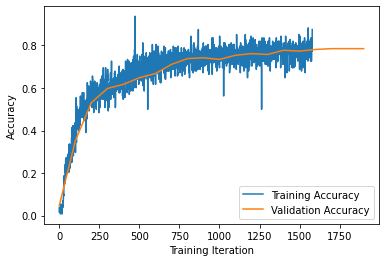

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()